$$
\newcommand{\fudm}[2]{\frac{\mathrm{D} #1}{\mathrm{D} #2}}
\newcommand{\pad}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ppad}[2]{\frac{\partial^2 #1}{\partial #2^2}}
\newcommand{\ppadd}[3]{\frac{\partial^2 #1}{\partial #2 \partial #3}}
\newcommand{\nnabla}{\nabla^2}
\newcommand{\eps}{\epsilon}
\newcommand{\vdetail}[1]{\vb{#1}=\begin{pmatrix}#1_1\\#1_2\\#1_3\end{pmatrix}}
\newcommand{\vb}[1]{\mathbf{#1}}
\newcommand{\va}[1]{\vec{#1}}
\newcommand{\vc}[1]{\begin{pmatrix}#1_1\\#1_2\end{pmatrix}}
\newcommand{\vd}[1]{\begin{pmatrix}#1_1\\#1_2\\#1_3\end{pmatrix}}
\newcommand{\tb}[1]{\underline{\underline{\mathbf{#1}}}}
\newcommand{\fud}[2]{\frac{\mathrm{d} #1}{\mathrm{d} #2}}
\newcommand{\dd}{\mathrm{d}}
$$

# Numerical Solution to the Laplace Equation


Let's solve the Laplace equation

$$\nabla^2\,\phi=0\tag{1}$$

subject to boundary conditions. This equation can be solved for sufficient simply boundary condition with a very simple iterative solver. This allows to demonstrate already at a very early stage of this fluid mechanics course the *power* of computational fluid mechanics. 

To get the problem understandable for the computer we write the equation in components

$$\ppad{\phi}{x}+\ppad{\phi}{y}=0\quad .\tag{2}$$

The simplest way to implement this equation into an algorithm is to discretize the equation. We solve it only on points $(x_i,y_j)$ of a mesh where $x_i=i\,\Delta x$ and $y_j=j\,\Delta y$ with $i,j=1...N$

We have thus to compute $\phi_{i,j}$, which demands that we discretize the Laplace operator $\nabla^2$. How are we going to do it? The approch which is working is surprisingly simple: we just express the partial derivative as finite differences. Let's start with the first derivative of $\phi$ with respect to $x$

$$\pad{\phi}{x}\approx\frac{\phi(x+\frac{1}{2}\Delta x)-\phi(x-\frac{1}{2}\Delta x)}{\Delta x}\tag{3}$$

Hence, the second derivative is

$$\ppad{\phi}{x}\approx\frac{1}{\Delta x} \frac{\phi(x+\Delta x)-\phi(x)-(\phi(x)-\phi(x-\Delta x))}{\Delta x}=
\frac{1}{\Delta x^2}\left[\phi(x+\Delta x)-2\phi(x)+\phi(x-\Delta x)\right]\tag{4}$$

To familiarize and check please repeat above calculations yourself. The expression can be written with our convenient $i,j$ notation. But before we make our life even simpler and use a homogeneous grid in $x$ and $y$-directions, $\Delta x=\Delta y$.
First we write the second derivative in $x$-direction

$$\left.\ppad{\phi}{x}\right|_{i,j}=\frac{1}{\Delta x^2}\left(\phi_{i+1,j}-2\phi_{i,j}+\phi_{i-1,j}\right)\tag{5}$$

The same holds for the $y$-direction:

$$\left.\ppad{\phi}{y}\right|_{i,j}=\frac{1}{\Delta x^2}\left(\phi_{i,j+1}-2\phi_{i,j}+\phi_{i,j-1}\right)\tag{6}$$

Now we can write the finite difference operation on $\nabla^2 \phi_{i,j}=0$ as

$$\phi_{i,j}=\frac{1}{4}\left(\phi_{i,j+1}+\phi_{i,j-1}+\phi_{i+1,j}+\phi_{i-1,j}\right)\quad .\tag{7}$$

If we want to calculate a specific flow we need to specify the boundary conditions. In this example we calculate the flow in a square geometry with the boundary conditions for the left, right, top, and bottom boundary.

<img src="files/pics/bc_extensional flow.png" width=300> <p> 

The left and right boundary have an inflow with a horizontal flow velocity $U_{wall}$ while the top and bottom boundary prescribe an outflow with $U_{wall}$. Let's look exemplarily to the left boundary: 

$$\left. u\right|_{i=1,j}=U_{wall}=\pad{\phi}{x}\approx\frac{\phi_{1,j}-\phi_{0,j}}{\Delta x}\tag{8}$$

Thus the value of $\phi$ for this boundary is:

$$\phi_{i=0,j}=\phi_{i=1,j}-U_{wall}\Delta x\tag{9}$$

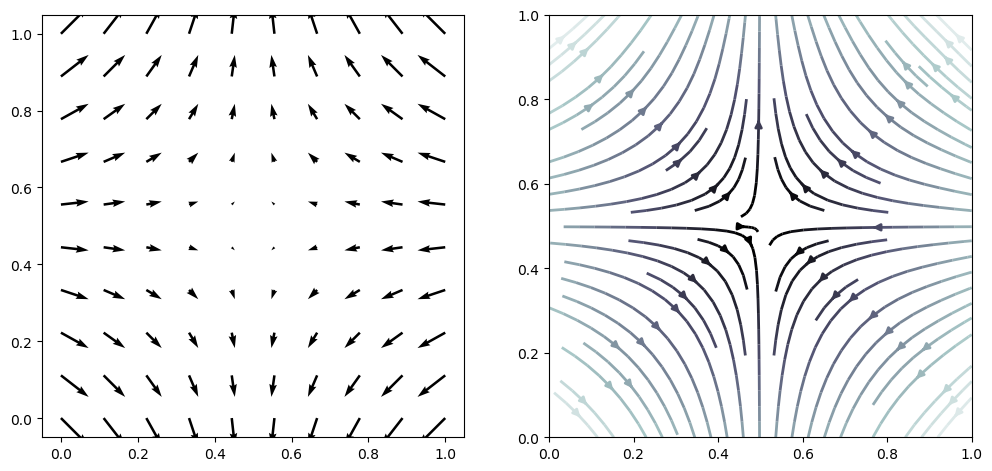

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

maxiter=100 #maximum number of iteration 

def solveLaplace_Jacobi(phi,deltax):
    phin = np.empty_like(phi)
    for iter in range (maxiter):
        phin=phi.copy()
        
        #boundary conditions
        #extensional flow
        phin[0,1:-1] = phin[1,1:-1]-Uwall*deltax #left
        phin[-1,1:-1] = phin[-2,1:-1]-Uwall*deltax #right
        phin[1:-1,0] = phin[1:-1,1]+Uwall*deltax #bottom
        phin[1:-1,-1] = phin[1:-1,-2]+Uwall*deltax #top
    
        #finite difference scheme
        for i in range(1,phin.shape[0]-1): 
            for j in range (1,phin.shape[1]-1):
                phi[i,j]=0.25*(phin[i-1,j]+phin[i+1,j]+phin[i,j-1]+phin[i,j+1])
    return phi

#Main program
n=13 #number of grid cells
L=1. #length of domain 
deltax=L/(n-1) #grid spacing
phi = np.zeros((n,n)) #initialize the velocity potential
Uwall=1. #Inflow velocity

#Solve Laplace equation
phi=solveLaplace_Jacobi(phi,deltax)

#Calculate the velocity fields (gradient of phi)
u1=(phi[1:,:]-phi[:-1,:])/deltax 
u2=(phi[:,1:]-phi[:,:-1])/deltax
#Omit the borders 
u1=u1[1:-1,1:-2]
u2=u2[1:-2,1:-1]

#setup the plot
x = y = np.linspace(0, L, n-3)
X, Y = np.meshgrid(x,y)
fig = plt.figure(figsize=(12,12), dpi=100) #figure size
ax1 = fig.add_subplot(1, 2, 1,aspect='equal') #two figures side-by-side
ax2 = fig.add_subplot(1, 2, 2,aspect='equal')

#arrow plot
ax1.quiver(X.T,Y.T,u1,u2)
#streamline plot
uabs=np.sqrt(u1**2+u2**2)
ax2.streamplot(X,Y,u1.T,u2.T,color=uabs.T, linewidth=2, cmap=plt.cm.bone);

In [4]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom2.css", "r").read()
    return HTML(styles)
css_styling()